In this tutorial, we implement a two-layer recurrent network that takes a sinusoidal signal and returns the same signal retarded in time. The network is constructed from scratch, without using predefined layers.

In [1]:
import math
import matplotlib.pyplot as plt
import torch

We consider signals of the form $\sin(t+\phi)$ where $\phi$ is an arbitrary phase shift and time $t$ runs from 0 to 10. We request that the net returns the same signal retarded by $\pi/2$. We digitize the signal into 101 frames with the step of 0.1 and consider a training set of 100 such signals with random values of $\phi$. Construct the training set and plot the first three data and target signals:

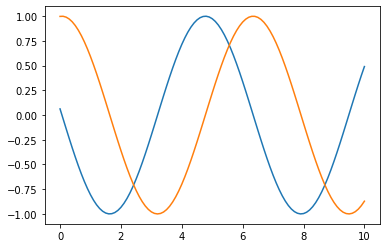

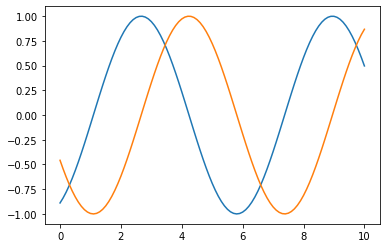

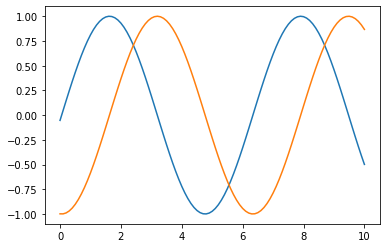

In [2]:
frames = 101
samples = 100

TIME = torch.linspace(0., 10., frames)
PHASE = 2. * math.pi * torch.rand(samples)
SIGNAL = torch.sin(TIME[:, None] + PHASE)
TARGET = torch.sin(TIME[:, None] + PHASE - math.pi / 2.)

for sample in range(3):
    plt.plot(TIME, SIGNAL[:, sample])
    plt.plot(TIME, TARGET[:, sample])
    plt.show()

The data and target are one-channel signals of the same structure as in the previous sum example, so the same one-layer recurrent network can be used as the first attempt. Train such network and plot the returned signal for the first three training samples:

0 1.1296682357788086
1 1.1184375286102295
2 1.1076010465621948
3 1.0971400737762451
4 1.0870367288589478
5 1.0772749185562134
6 1.0678387880325317
7 1.0587139129638672
8 1.04988694190979
9 1.0413445234298706
10 1.0330743789672852
11 1.0250648260116577
12 1.0173043012619019
13 1.009782314300537
14 1.0024876594543457
15 0.9954103231430054
16 0.9885401725769043
17 0.981867253780365
18 0.9753819108009338
19 0.9690741300582886
20 0.9629347920417786
21 0.9569544792175293
22 0.9511238932609558
23 0.9454345107078552
24 0.9398770928382874
25 0.9344438314437866
26 0.9291263818740845
27 0.9239174723625183
28 0.9188099503517151
29 0.9137970805168152
30 0.9088729619979858
31 0.9040321111679077
32 0.8992695212364197
33 0.8945806622505188
34 0.8899614214897156
35 0.8854085803031921
36 0.8809191584587097
37 0.8764899969100952
38 0.8721193075180054
39 0.8678046464920044
40 0.8635444641113281
41 0.8593369722366333
42 0.8551812171936035
43 0.8510754704475403
44 0.8470189571380615
45 0.8430107235908508
46

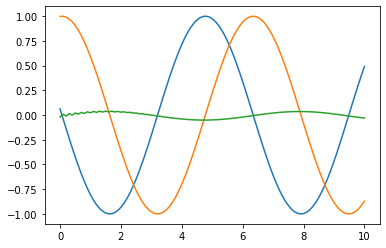

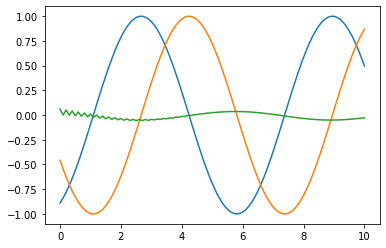

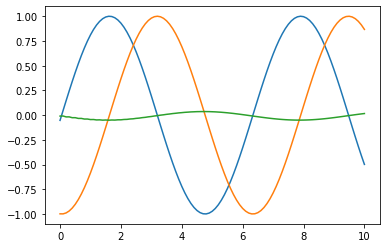

In [3]:
BIAS1 = torch.randn((), requires_grad = True)
WEIGHT1F = torch.randn((), requires_grad = True)
WEIGHT1S = torch.randn((), requires_grad = True)

def cell(FRAME, STATE):
    ACTIVATION = BIAS1 + FRAME * WEIGHT1F + STATE * WEIGHT1S
    ACTIVITY = ACTIVATION
    return ACTIVITY

def model(SIGNAL):
    frames, samples = SIGNAL.size(0), SIGNAL.size(1)
    ACTIVITY1 = torch.empty(frames, samples)
    STATE = torch.zeros(samples)
    for frame in range(frames):
        STATE = cell(SIGNAL[frame], STATE)
        ACTIVITY1[frame] = STATE
    return ACTIVITY1

optimizer = torch.optim.SGD([BIAS1, WEIGHT1F, WEIGHT1S], lr = 0.01)
for epoch in range(1000):
    RESULT = model(SIGNAL)
    LOSS = torch.square(RESULT - TARGET).mean()
    optimizer.zero_grad()
    LOSS.backward()
    optimizer.step()
    print(epoch, LOSS.item())

RESULT = model(SIGNAL).detach()

for sample in range(3):
    plt.plot(TIME, SIGNAL[:, sample])
    plt.plot(TIME, TARGET[:, sample])
    plt.plot(TIME, RESULT[:, sample])
    plt.show()

The resulting signal is already a sinusoid but far from the desired target in both amplitude and phase. Note that the retardation of $\pi/2$ corresponds to about 16 frames that the net needs to remember in the hidden state. So, the current single-valued hidden state is not sufficient and we will transform it into a sequence of 16 numbers. As the first step, replace the scalar bias and weights with matrices of appropriate shapes so that the recurrent cell take and return a hidden state of size 16:

In [4]:
size1 = 16

BIAS1 = torch.randn(size1, requires_grad = True)
WEIGHT1F = torch.randn(1, size1, requires_grad = True)
WEIGHT1S = torch.randn(size1, size1, requires_grad = True)

def cell(FRAME, STATE):
    ACTIVATION = BIAS1 + FRAME[:, None] @ WEIGHT1F + STATE @ WEIGHT1S
    ACTIVITY = ACTIVATION
    return ACTIVITY

In the next step, add a rightmost dimension of size 16 to all variables holding hidden states in the model:

In [5]:
def model(SIGNAL):
    frames, samples = SIGNAL.size(0), SIGNAL.size(1)
    ACTIVITY1 = torch.empty(frames, samples, size1)
    STATE = torch.zeros(samples, size1)
    for frame in range(frames):
        STATE = cell(SIGNAL[frame], STATE)
        ACTIVITY1[frame] = STATE
    return ACTIVITY1

After these modifications, the model returns a 16-channel signal. It cannot be directly compared against the one-channel target signal. Transform the 16 channels back to 1 by applying a linear transformation to each frame separately:

In [6]:
BIAS2 = torch.randn(1, requires_grad = True)
WEIGHT2 = torch.randn(size1, 1, requires_grad = True)

def model(SIGNAL):
    frames, samples = SIGNAL.size(0), SIGNAL.size(1)
    ACTIVITY1 = torch.empty(frames, samples, size1)
    STATE = torch.zeros(samples, size1)
    for frame in range(frames):
        STATE = cell(SIGNAL[frame], STATE)
        ACTIVITY1[frame] = STATE
    ACTIVATION2 = torch.empty(frames, samples, 1)
    for frame in range(frames):
        ACTIVATION2[frame] = BIAS2 + ACTIVITY1[frame] @ WEIGHT2
    ACTIVITY2 = ACTIVATION2
    return ACTIVITY2

The model now has two layers, of which the first is recurrent and the second is linear or dense or fully connected. Each layer takes a signal and returns another signal, which generally has a different number of channels. The output from the first layer is passed to the second layer, so this is a sequential model. Add the parameters of the new linear transform to the optimizer and run the training loop:

In [7]:
optimizer = torch.optim.SGD([BIAS1, WEIGHT1F, WEIGHT1S, BIAS2, WEIGHT2], lr = 0.01)
for epoch in range(1000):
    RESULT = model(SIGNAL)
    LOSS = torch.square(RESULT - TARGET[:, :, None]).mean()
    optimizer.zero_grad()
    LOSS.backward()
    optimizer.step()
    print(epoch, LOSS.item())

0 nan
1 nan
2 nan
3 nan
4 nan
5 nan
6 nan
7 nan
8 nan
9 nan
10 nan
11 nan
12 nan
13 nan
14 nan
15 nan
16 nan
17 nan
18 nan
19 nan
20 nan
21 nan
22 nan
23 nan
24 nan
25 nan
26 nan
27 nan
28 nan
29 nan
30 nan
31 nan
32 nan
33 nan
34 nan
35 nan
36 nan
37 nan
38 nan
39 nan
40 nan
41 nan
42 nan
43 nan
44 nan
45 nan
46 nan
47 nan
48 nan
49 nan
50 nan
51 nan
52 nan
53 nan
54 nan
55 nan
56 nan
57 nan
58 nan
59 nan
60 nan
61 nan
62 nan
63 nan
64 nan
65 nan
66 nan
67 nan
68 nan
69 nan
70 nan
71 nan
72 nan
73 nan
74 nan
75 nan
76 nan
77 nan
78 nan
79 nan
80 nan
81 nan
82 nan
83 nan
84 nan
85 nan
86 nan
87 nan
88 nan
89 nan
90 nan
91 nan
92 nan
93 nan
94 nan
95 nan
96 nan
97 nan
98 nan
99 nan
100 nan
101 nan
102 nan
103 nan
104 nan
105 nan
106 nan
107 nan
108 nan
109 nan
110 nan
111 nan
112 nan
113 nan
114 nan
115 nan
116 nan
117 nan
118 nan
119 nan
120 nan
121 nan
122 nan
123 nan
124 nan
125 nan
126 nan
127 nan
128 nan
129 nan
130 nan
131 nan
132 nan
133 nan
134 nan
135 nan
136 nan
137 nan
138 na

No matter how hard we try, we always get nans. The network is already complex enough so that its parameters must be initialized more carefully. Use the initialization from Xavier Glorot. If you still get nans, try many many times and it will finally work:

0 18.609952926635742
1 0.8937494158744812
2 0.733046293258667
3 0.6808960437774658
4 0.6492248177528381
5 0.6251490712165833
6 0.606156051158905
7 0.5907421112060547
8 0.5779452323913574
9 0.5671170949935913
10 0.5578035712242126
11 0.5496752262115479
12 0.5424875020980835
13 0.536053478717804
14 0.5302283763885498
15 0.524897575378418
16 0.5199686884880066
17 0.5153663754463196
18 0.511028528213501
19 0.5069025754928589
20 0.502943754196167
21 0.4991135895252228
22 0.4953781068325043
23 0.491706907749176
24 0.4880724549293518
25 0.48444926738739014
26 0.48081305623054504
27 0.4771406948566437
28 0.47340908646583557
29 0.4695951044559479
30 0.4656747877597809
31 0.4616231620311737
32 0.4574132561683655
33 0.4530155062675476
34 0.4483972191810608
35 0.4435211718082428
36 0.4383450150489807
37 0.4328188896179199
38 0.4268844723701477
39 0.4204714000225067
40 0.4134948253631592
41 0.40584999322891235
42 0.39740633964538574
43 0.3879985213279724
44 0.37741389870643616
45 0.3653744161128998

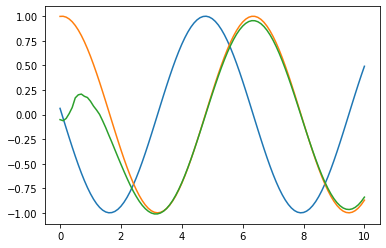

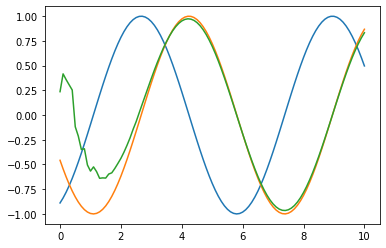

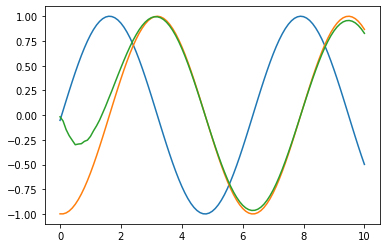

In [11]:
BIAS1 = torch.zeros(size1, requires_grad = True)
WEIGHT1F = torch.empty(1, size1, requires_grad = True)
WEIGHT1S = torch.empty(size1, size1, requires_grad = True)
BIAS2 = torch.zeros(1, requires_grad = True)
WEIGHT2 = torch.empty(size1, 1, requires_grad = True)

torch.nn.init.xavier_normal_(WEIGHT1F)
torch.nn.init.xavier_normal_(WEIGHT1S)
torch.nn.init.xavier_normal_(WEIGHT2)

def cell(FRAME, STATE):
    ACTIVATION = BIAS1 + FRAME[:, None] @ WEIGHT1F + STATE @ WEIGHT1S
    ACTIVITY = ACTIVATION
    return ACTIVITY

def model(SIGNAL):
    frames, samples = SIGNAL.size(0), SIGNAL.size(1)
    ACTIVITY1 = torch.empty(frames, samples, size1)
    STATE = torch.zeros(samples, size1)
    for frame in range(frames):
        STATE = cell(SIGNAL[frame], STATE)
        ACTIVITY1[frame] = STATE
    ACTIVATION2 = torch.empty(frames, samples, 1)
    for frame in range(frames):
        ACTIVATION2[frame] = BIAS2 + ACTIVITY1[frame] @ WEIGHT2
    ACTIVITY2 = ACTIVATION2
    return ACTIVITY2

optimizer = torch.optim.SGD([BIAS1, WEIGHT1F, WEIGHT1S, BIAS2, WEIGHT2], lr = 0.01)
for epoch in range(1000):
    RESULT = model(SIGNAL)
    LOSS = torch.square(RESULT - TARGET[:, :, None]).mean()
    optimizer.zero_grad()
    LOSS.backward()
    optimizer.step()
    print(epoch, LOSS.item())

RESULT = model(SIGNAL).detach()

for sample in range(3):
    plt.plot(TIME, SIGNAL[:, sample])
    plt.plot(TIME, TARGET[:, sample])
    plt.plot(TIME, RESULT[:, sample, 0])
    plt.show()

The net reproduces the retarded signal almost perfectly except for the begining. But this is understandable and inevitable, because there is no information on the signal before time zero. One curiosity is that our network currently contains no activation functions, so we reproduced a non-linear signal by using only linear operations. In several places of the current script, we need to repeatedly unsqueeze the signal by adding the last dimension of size 1. Instead, permanently add that dimension already at the beginning:

0 2.08143949508667
1 0.8626125454902649
2 0.8089609742164612
3 0.7714800834655762
4 0.7429648637771606
5 0.7199240922927856
6 0.7004692554473877
7 0.6834977865219116
8 0.6683251261711121
9 0.6545039415359497
10 0.6417272686958313
11 0.6297746896743774
12 0.6184815168380737
13 0.607718825340271
14 0.5973820090293884
15 0.587382435798645
16 0.5776423215866089
17 0.5680904388427734
18 0.558659017086029
19 0.5492815375328064
20 0.5398899912834167
21 0.5304126739501953
22 0.5207715034484863
23 0.5108789205551147
24 0.5006334781646729
25 0.48991453647613525
26 0.4785742163658142
27 0.46642670035362244
28 0.4532327950000763
29 0.4386774003505707
30 0.4223357141017914
31 0.4036197066307068
32 0.38168901205062866
33 0.35529887676239014
34 0.3225468397140503
35 0.28050708770751953
36 0.22512666881084442
37 0.15480124950408936
38 0.09553021937608719
39 0.08989421278238297
40 0.08954595774412155
41 0.08884764462709427
42 0.09080091118812561
43 0.09002885222434998
44 0.09665088355541229
45 0.091711

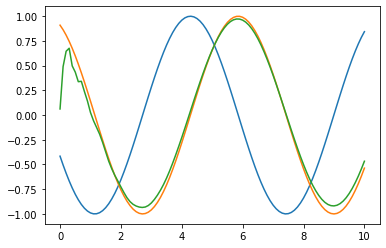

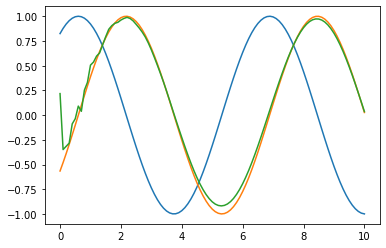

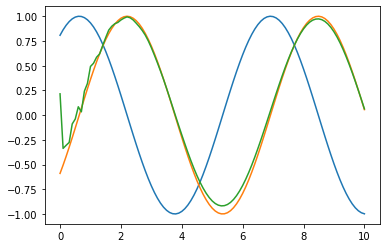

In [12]:
TIME = torch.linspace(0., 10., frames)
PHASE = 2. * math.pi * torch.rand(samples, 1)
SIGNAL = torch.sin(TIME[:, None, None] + PHASE)
TARGET = torch.sin(TIME[:, None, None] + PHASE - math.pi / 2.)

BIAS1 = torch.zeros(size1, requires_grad = True)
WEIGHT1F = torch.empty(1, size1, requires_grad = True)
WEIGHT1S = torch.empty(size1, size1, requires_grad = True)
BIAS2 = torch.zeros(1, requires_grad = True)
WEIGHT2 = torch.empty(size1, 1, requires_grad = True)

torch.nn.init.xavier_normal_(WEIGHT1F)
torch.nn.init.xavier_normal_(WEIGHT1S)
torch.nn.init.xavier_normal_(WEIGHT2)

def cell(FRAME, STATE):
    ACTIVATION = BIAS1 + FRAME @ WEIGHT1F + STATE @ WEIGHT1S
    ACTIVITY = ACTIVATION
    return ACTIVITY

def model(SIGNAL):
    frames, samples = SIGNAL.size(0), SIGNAL.size(1)
    ACTIVITY1 = torch.empty(frames, samples, size1)
    STATE = torch.zeros(samples, size1)
    for frame in range(frames):
        STATE = cell(SIGNAL[frame], STATE)
        ACTIVITY1[frame] = STATE
    ACTIVATION2 = torch.empty(frames, samples, 1)
    for frame in range(frames):
        ACTIVATION2[frame] = BIAS2 + ACTIVITY1[frame] @ WEIGHT2
    ACTIVITY2 = ACTIVATION2
    return ACTIVITY2

optimizer = torch.optim.SGD([BIAS1, WEIGHT1F, WEIGHT1S, BIAS2, WEIGHT2], lr = 0.01)
for epoch in range(1000):
    RESULT = model(SIGNAL)
    LOSS = torch.square(RESULT - TARGET).mean()
    optimizer.zero_grad()
    LOSS.backward()
    optimizer.step()
    print(epoch, LOSS.item())

RESULT = model(SIGNAL).detach()

for sample in range(3):
    plt.plot(TIME, SIGNAL[:, sample, 0])
    plt.plot(TIME, TARGET[:, sample, 0])
    plt.plot(TIME, RESULT[:, sample, 0])
    plt.show()

The rightmost extra dimension is not artificial, because in other problems both the input and output signal may have an arbitrary number of channels. Introduce appropriate variables for the number of channels at each stage and the model will become general enough to deal with any signal:

0 0.5592605471611023
1 0.5482993125915527
2 0.5387161374092102
3 0.5301270484924316
4 0.5222446918487549
5 0.5148425102233887
6 0.5077317953109741
7 0.5007450580596924
8 0.49372243881225586
9 0.4865001440048218
10 0.47889700531959534
11 0.47069859504699707
12 0.4616350531578064
13 0.4513467848300934
14 0.43932870030403137
15 0.42483288049697876
16 0.4066888689994812
17 0.3829500079154968
18 0.3501623272895813
19 0.30186063051223755
20 0.22660411894321442
21 0.12176349014043808
22 0.10063943266868591
23 0.14209569990634918
24 0.08542180061340332
25 0.09416720271110535
26 0.09456589818000793
27 0.1336977183818817
28 0.0797577053308487
29 0.08546901494264603
30 0.08563892543315887
31 0.107817143201828
32 0.08230356872081757
33 0.09891136735677719
34 0.08183357119560242
35 0.09917433559894562
36 0.07948426157236099
37 0.09369125217199326
38 0.07854816317558289
39 0.09225279837846756
40 0.07712794840335846
41 0.08937480300664902
42 0.07605096697807312
43 0.08739570528268814
44 0.07501196861

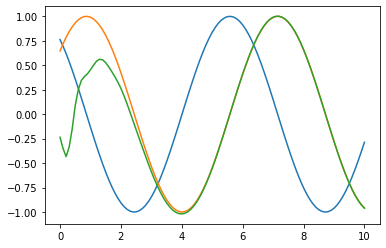

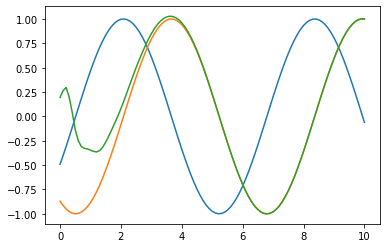

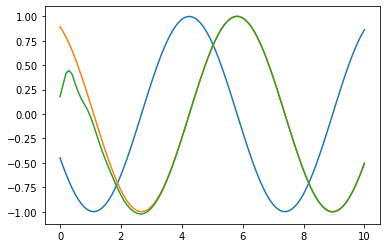

In [13]:
size0, size1, size2 = 1, 16, 1

TIME = torch.linspace(0., 10., frames)
PHASE = 2. * math.pi * torch.rand(samples, size0)
SIGNAL = torch.sin(TIME[:, None, None] + PHASE)
TARGET = torch.sin(TIME[:, None, None] + PHASE - math.pi / 2.)

BIAS1 = torch.zeros(size1, requires_grad = True)
WEIGHT1F = torch.empty(size0, size1, requires_grad = True)
WEIGHT1S = torch.empty(size1, size1, requires_grad = True)
BIAS2 = torch.zeros(size2, requires_grad = True)
WEIGHT2 = torch.empty(size1, size2, requires_grad = True)

torch.nn.init.xavier_normal_(WEIGHT1F)
torch.nn.init.xavier_normal_(WEIGHT1S)
torch.nn.init.xavier_normal_(WEIGHT2)

def cell(FRAME, STATE):
    ACTIVATION = BIAS1 + FRAME @ WEIGHT1F + STATE @ WEIGHT1S
    ACTIVITY = ACTIVATION
    return ACTIVITY

def model(SIGNAL):
    frames, samples = SIGNAL.size(0), SIGNAL.size(1)
    ACTIVITY1 = torch.empty(frames, samples, size1)
    STATE = torch.zeros(samples, size1)
    for frame in range(frames):
        STATE = cell(SIGNAL[frame], STATE)
        ACTIVITY1[frame] = STATE
    ACTIVATION2 = torch.empty(frames, samples, size2)
    for frame in range(frames):
        ACTIVATION2[frame] = BIAS2 + ACTIVITY1[frame] @ WEIGHT2
    ACTIVITY2 = ACTIVATION2
    return ACTIVITY2

optimizer = torch.optim.SGD([BIAS1, WEIGHT1F, WEIGHT1S, BIAS2, WEIGHT2], lr = 0.01)
for epoch in range(1000):
    RESULT = model(SIGNAL)
    LOSS = torch.square(RESULT - TARGET).mean()
    optimizer.zero_grad()
    LOSS.backward()
    optimizer.step()
    print(epoch, LOSS.item())

RESULT = model(SIGNAL).detach()

for sample in range(3):
    plt.plot(TIME, SIGNAL[:, sample, 0])
    plt.plot(TIME, TARGET[:, sample, 0])
    plt.plot(TIME, RESULT[:, sample, 0])
    plt.show()

The irritating nans are due to the exploding-gradients problem. It affects all neural networks, but recurrent ones are particularly vulnerable. If the bias or weights get excessively large, the recurrent cell produces an overly large hidden state. It is fed back to the recurrent cell and gets multiplied by the too-large weights until everything explodes. One remedy is to add the hyperbolic tangens as the activation function in the recurrent cell. It yields values from -1 to 1, so prevents them from getting too large. The hyperbolic tangens is the standard activation for recurrent networks and the default in PyTorch predefined components:

0 0.6668763756752014
1 0.48144420981407166
2 0.37077397108078003
3 0.2931438982486725
4 0.235408753156662
5 0.1917516440153122
6 0.15889206528663635
7 0.13448677957057953
8 0.11660300940275192
9 0.10361826419830322
10 0.09423141926527023
11 0.08745196461677551
12 0.08255176246166229
13 0.07900431752204895
14 0.0764305517077446
15 0.07455747574567795
16 0.07318820804357529
17 0.07218069583177567
18 0.07143254578113556
19 0.0708700567483902
20 0.07044023275375366
21 0.07010510563850403
22 0.0698375254869461
23 0.06961807608604431
24 0.06943294405937195
25 0.06927227973937988
26 0.0691291093826294
27 0.06899845600128174
28 0.06887684017419815
29 0.06876175105571747
30 0.06865145266056061
31 0.06854469329118729
32 0.06844062358140945
33 0.06833859533071518
34 0.06823820620775223
35 0.06813912093639374
36 0.06804114580154419
37 0.06794413179159164
38 0.06784795969724655
39 0.06775255501270294
40 0.06765786558389664
41 0.06756386160850525
42 0.0674705058336258
43 0.06737777590751648
44 0.067

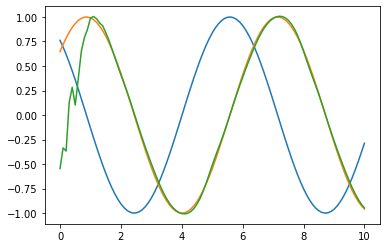

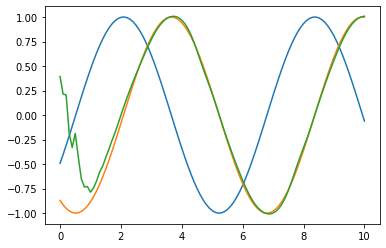

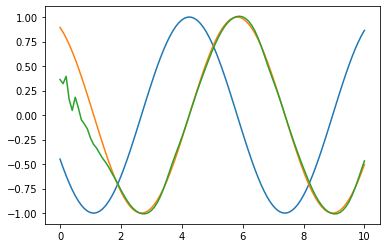

In [14]:
BIAS1 = torch.zeros(size1, requires_grad = True)
WEIGHT1F = torch.empty(size0, size1, requires_grad = True)
WEIGHT1S = torch.empty(size1, size1, requires_grad = True)
BIAS2 = torch.zeros(size2, requires_grad = True)
WEIGHT2 = torch.empty(size1, size2, requires_grad = True)

torch.nn.init.xavier_normal_(WEIGHT1F)
torch.nn.init.xavier_normal_(WEIGHT1S)
torch.nn.init.xavier_normal_(WEIGHT2)

def cell(FRAME, STATE):
    ACTIVATION = BIAS1 + FRAME @ WEIGHT1F + STATE @ WEIGHT1S
    ACTIVITY = torch.tanh(ACTIVATION)
    return ACTIVITY

def model(SIGNAL):
    frames, samples = SIGNAL.size(0), SIGNAL.size(1)
    ACTIVITY1 = torch.empty(frames, samples, size1)
    STATE = torch.zeros(samples, size1)
    for frame in range(frames):
        STATE = cell(SIGNAL[frame], STATE)
        ACTIVITY1[frame] = STATE
    ACTIVATION2 = torch.empty(frames, samples, size2)
    for frame in range(frames):
        ACTIVATION2[frame] = BIAS2 + ACTIVITY1[frame] @ WEIGHT2
    ACTIVITY2 = ACTIVATION2
    return ACTIVITY2

optimizer = torch.optim.SGD([BIAS1, WEIGHT1F, WEIGHT1S, BIAS2, WEIGHT2], lr = 0.01)
for epoch in range(1000):
    RESULT = model(SIGNAL)
    LOSS = torch.square(RESULT - TARGET).mean()
    optimizer.zero_grad()
    LOSS.backward()
    optimizer.step()
    print(epoch, LOSS.item())

RESULT = model(SIGNAL).detach()

for sample in range(3):
    plt.plot(TIME, SIGNAL[:, sample, 0])
    plt.plot(TIME, TARGET[:, sample, 0])
    plt.plot(TIME, RESULT[:, sample, 0])
    plt.show()

With the hyperbolic tangens, we no more get the nans, but the resulting signal is a bit ugly and does not follow the target so well. We will deal with this in the next example.